# Assorting Tomatoes

### CV home task

#### By Nimrod Dvir

When I addressed this assignment I had some ideas in mind for algorithms to try out. Eventually, I chose the Hough Line Transform method to detect circles, as I found it more robust and less cumbersome comparing to segmentation and contours searching methods, which required a compound level of image processing, that is not only hard to optimize, but also totaly different for other images.

Of course, the importance of robustness, running time and accuracy (and more issues) are matters to be clarified with the product representative. Because (as I understand) this discussion is not part of the test, I chose to:
1. Have some robustness - With only tuning of some hyper parameters it is possible to get good results on other images of tomatoes (or other circular objects) as well.
2. Simplicity - A code which is easy to understand and adjust in need.
3. Balance between finding more tomatoes and finding "fruits of imagination" - This can be easily modulate by tuning the hyper parameters.

Three remarks regarding the code:
1. The main decision in the code which requires explanation is that the HoughCircles method is applied twice. I found out that splitting the search for two different sizes of circles (with distinct hyper parameters) helps to get a better balance regarding the accuracy ("pay less" in the tradeoff between more detected and false detected).
2. To find the optimal HSV threshold values, for the sake of the "Color v.s. Radius" scatter plot, I used a nice script, which I put in the end of this notebook.
3. Although this stand-alone task did not required it, I built the code using a function, to make it easier to test other images and tune the parameters (the defaults for the parameters are the best I found for the given image "assorted_tomatoes.jpg").

In [22]:
# Importing the required modules 

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
import itertools
from scipy.spatial import distance_matrix

In [23]:
def tomatoes_detector (image_path, fx=1, fy=1, blur_ksize=5,
                      minDist_small=50, param1_small=50, param2_small=20, minRadius_small=25, maxRadius_small=49,
                      minDist_big=100, param1_big=50, param2_big=40, minRadius_big=50, maxRadius_big=90,
                      minDist_cross=0, plot_colorVSradius = True, save_outputs = False):
    """
    Inputs:
    
        image_path = The path to the source image.
        
        fx, fy = Factors to resize the image if it is too big or small.
        
        blur_ksize = Aperture linear size for the medianBlur filter (larger -> less sensitive detector).
        
        minDist_small, param1_small, param2_small, minRadius_small, maxRadius_small =
            The parameters for the HoughCircles method for finding small circles.
            
        minDist_big, param1_big, param2_big, minRadius_big, maxRadius_big =
            The parameters for the HoughCircles method for finding big circles
            # Remark 1: When no need for two different sizes, set the same values as for the "_small" parameters.
            
        # Remark 2: Tuning the 'param2_[size]' parameters is the easiest way to adjust the detector's sensitivity
                   (larger -> less sensitive).
        
        minDist_cross = Minimal distance between centers of 'small circles' and 'big circles'.
            Set to 0 to get the default, which is the average of 'minRadius_big' and 'maxRadius_big'.
            
        plot_colorVSradius = Boolian 'True' for plotting a scatter plot of tomato color v.s. its radius.
        
        save_outputs = Boolian 'True' for saving the output image and the scatter plot to files.
        
    Output:
        Return a list of all circles found (center's coordinates and radius).
        Plot of the source image with the tomatoes (or other circular objects) detected encircled.
        Plot a scatter plot of tomato color v.s. its radius (by demand).
        Save the outputs to files (by demand).

    """

    img = cv2.imread(image_path)

    # Preprocessing:
    img = cv2.resize(img, (0, 0), fx=fx, fy=fy)                 # Resizing if necessary
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, blur_ksize)                  # Helps avoiding false detections

    # Detecting circles:
    small_circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist_small, param1=param1_small, param2=param2_small,
                                     minRadius=minRadius_small, maxRadius=maxRadius_small)
    big_circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, 1, minDist_big, param1=param1_big, param2=param2_big,
                                   minRadius=minRadius_big, maxRadius=maxRadius_big)
    
    # Break if there no circles found:
    assert small_circles is not None, "No small circles had been detected, try to adjust the parameters"
    assert big_circles is not None, "No big circles had been detected, try to adjust the parameters"
    
    # The HoughCircle method's output has a redundant dimension:
    small_circles = np.squeeze(small_circles, axis=0)
    big_circles = np.squeeze(big_circles, axis=0)
    
    # Removing small circles detected inside big circles:
    if minDist_cross==0:
        minDist_cross = np.mean([minRadius_big, maxRadius_big])
    # Creating a matrix with all distances between small circles' and big circles' centers:
    dist_mat = distance_matrix(small_circles[:,[0,1]], big_circles[:,[0,1]])
    small_circles = np.delete(small_circles, np.where(dist_mat < minDist_cross)[0], 0)

    # Group all the remianing circles:
    detected_circles = np.uint16(np.floor(np.concatenate((big_circles, small_circles), axis=0)))
    
    if plot_colorVSradius == True:
        
        # Convert the image to the HSV format for detection of colors:
        hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_image)
        # Intialize the color dictionary: 
        radius_by_color = {'red':[],'brown':[], 'green':[], 'yellow':[]}
        
    for (x, y, r) in detected_circles:
        
        # Draw the circles:
        cv2.circle(img, (x, y), r, (255, 255, 0), 2)
        cv2.circle(img, (x, y), 2, (255, 255, 0), 3)
        
        # Sort the circles to color:
        if plot_colorVSradius == True:
            if h[y,x] < 13 or h[y,x] > 130:
                if v[y,x] > 165:
                    radius_by_color['red'].append(r)
                else:
                    radius_by_color['brown'].append(r)
            elif 13 <= h[y,x] < 29:
                radius_by_color['yellow'].append(r)
            else :
                radius_by_color['green'].append(r)

    # Plotting the image with the items encircled:
    figy = img.shape[0] / 100 * 1.5
    figx = img.shape[1] / 100 * 1.5
    plt.figure(figsize = (figx,figy))
    plt.xticks([]), plt.yticks([])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

    # Saving the result to a file:
    if save_outputs == True:
        cv2.imwrite('encircled_tomatoes.jpg', img)
    
    if plot_colorVSradius == True:
        
        # "Lay out" the dictionary:
        color = []
        radius = []
        for c, r in radius_by_color.items():
            color.extend(list(itertools.repeat(c, len(r))))
            radius.extend(r)
            
        # Plotting the Color vs. Radius graph:
        plt.figure(figsize = (8,6))
        plt.plot(color, radius, 'bo')
        plt.title('Color vs. Radius', fontsize=16)
        plt.ylabel('Radius', fontsize=12)
        plt.xticks(fontsize=12)
        
        plt.show()
        
        # Saving the plot to a file:
        if save_outputs == True:
            plt.savefig('plot_color_vs_radius.jpg')

    return detected_circles

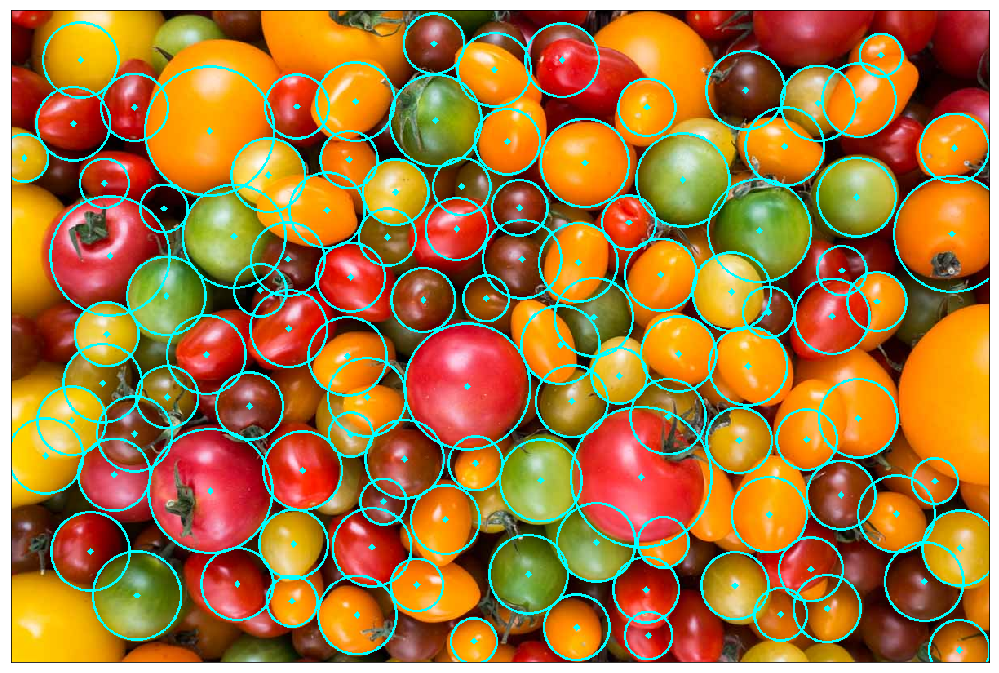

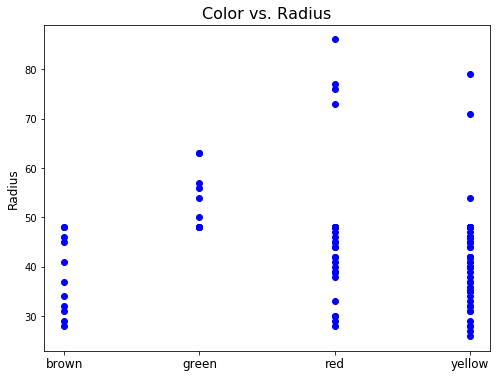

Number of tomatoes detected: 109.


In [24]:
image_path = 'C:/Users/dvirn/Documents/Data Science/assorted_tomatoes.jpg'
detected_tomatoes = tomatoes_detector(image_path, save_outputs=True)
print("Number of tomatoes detected: {}.".format(detected_tomatoes.shape[0]))

###### Inference:

1. It is plausible to see that a big majority of the tomatoes had been detected while only one circle marks nothing. If we want to encircle more objects, and don't mind more made-up tomatoes, we can achieve it by lowering the blur_ksize or the param2_small parameters (from my checkup, the ratio is one false for each additional tomatoe detected). In my opinion, this is the best balance.
2. Not all circles are accurate, while the asymmetric tomatoes do not follow a regular principle (sometimes by the small radius and sometimes by the big). However, I think that on the accuracy v.s. complexity balance, this is a fair spot to be on. I guess that more accurate results might be achieved by using methods of segmentaion or contours detection, but my tries yield much less accurate detectors (while having more disadvantages as elborated above), so this is my best result on that matter.

###### Now, some robustness evidence:

I have mentioned robustness, so here is a small test for this issue, using a resembling image:

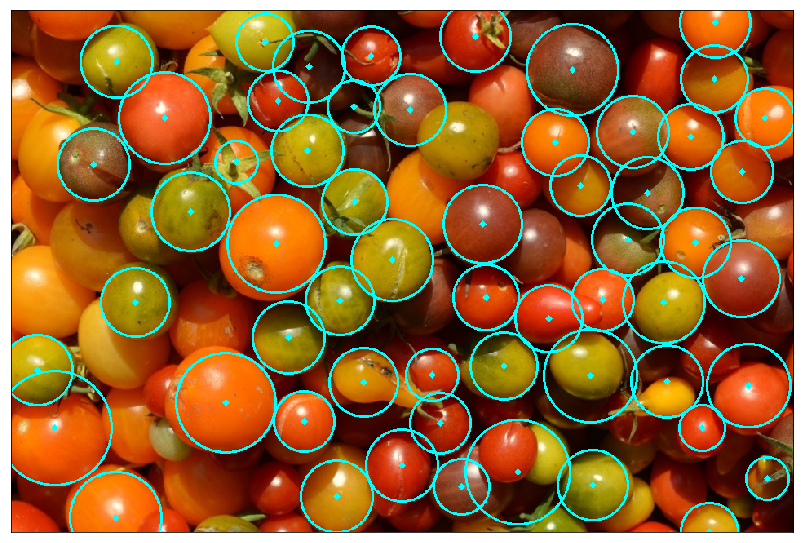

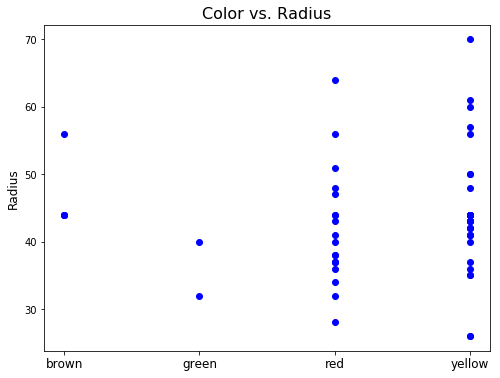

Number of tomatoes detected: 57.


In [25]:
image_path = 'C:/Users/dvirn/Documents/Data Science/assorted_tomatoes2.jpg'
detected_tomatoes = tomatoes_detector(image_path, maxRadius_small=45, param2_small=22,
                                      minDist_big=90, param2_big=30, minRadius_big=46, maxRadius_big=80)
print("Number of tomatoes detected: {}.".format(detected_tomatoes.shape[0]))

One can see, that with a tuning of the parameters, similar results in their detection quality are obtained. Another observation is that the the group of colors are a bit different in this image and requires an adjustment (maybe adding orange and green-yellow ones as in-between colors).

When applying this function on a simpler image, perfect detection can be attained:

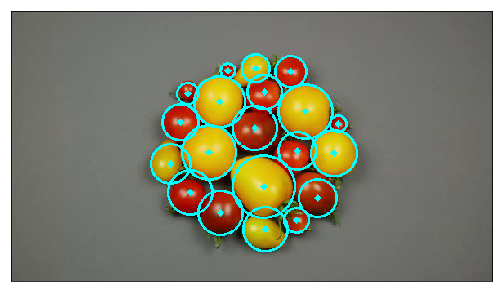

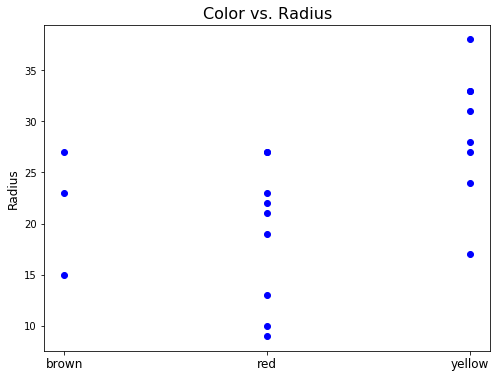

Number of tomatoes detected: 20.


In [26]:
image_path = 'C:/Users/dvirn/Documents/Data Science/assorted_tomatoes3.jpg'
detected_tomatoes = tomatoes_detector(image_path, minDist_small=25, param2_small=18,  minRadius_small=5, maxRadius_small=29,
                                      minDist_big=50, param2_big=20, minRadius_big=30, maxRadius_big=40)
print("Number of tomatoes detected: {}.".format(detected_tomatoes.shape[0]))

###### "Behind the Scenes" Bonus:

As promissed, below is a nice script for finding the optimal HSV threshold values in favor of sorting the tomatoes by color (full disclosure: it is taken from an online course). One can play with the controllers to bring out certain colors in the image. Press the 'Esc' button to close the windows (or else the notebook gets stuck).

In [27]:
def nothing(x):
    pass

cv2.namedWindow('HSI control bars')
# Low thresholds:
cv2.createTrackbar('LH', 'HSI control bars', 0, 180, nothing)
cv2.createTrackbar('LS', 'HSI control bars', 0, 255, nothing)
cv2.createTrackbar('LV', 'HSI control bars', 0, 255, nothing)
# High thresholds:
cv2.createTrackbar('UH', 'HSI control bars', 180, 180, nothing)
cv2.createTrackbar('US', 'HSI control bars', 255, 255, nothing)
cv2.createTrackbar('UV', 'HSI control bars', 255, 255, nothing)

while True:
    image = cv2.imread('C:/Users/dvirn/Documents/Data Science/assorted_tomatoes2.jpg')
    image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    l_h = cv2.getTrackbarPos('LH', "HSI control bars")
    l_s = cv2.getTrackbarPos('LS', "HSI control bars")
    l_v = cv2.getTrackbarPos('LV', "HSI control bars")

    u_h = cv2.getTrackbarPos('UH', "HSI control bars")
    u_s = cv2.getTrackbarPos('US', "HSI control bars")
    u_v = cv2.getTrackbarPos('UV', "HSI control bars")

    l_b = np.array([l_h,l_s,l_v])
    u_b = np.array([u_h,u_s,u_v])

    mask = cv2.inRange(hsv, l_b, u_b)

    output = cv2.bitwise_and(image, image, mask=mask)

    cv2.imshow('Image', image)
    cv2.imshow('Mask', mask)
    cv2.imshow('Output', output)

    key = cv2.waitKey(1)
    if key == 27:
        break
        
cv2.destroyAllWindows()